In [3]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import xgboost as xgb
import shap
import datetime
import warnings
warnings.filterwarnings("ignore")

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

Added: /Users/lsanchez/omath_mota_rulo


In [4]:
from data_scientia.features import train_data
from data_scientia.models.eval import eval_utils

In [5]:
data_ = train_data.get()

data_.shape

(10845, 71)

In [6]:
data_ = data_[data_['fecha'] < '2020-11-12']

In [7]:
contagios_cols = [x for x in data_.columns if 'contagios' in x]
contagios_7_cols = [x for x in contagios_cols if '7' in x]
contagios_15_cols = [x for x in contagios_cols if '15' in x]
contagios_cols = list(set(contagios_cols) - set(contagios_7_cols) - set(contagios_15_cols))

target = 'is_next_peak_in_15_days'
forbiden = list(set([
    'is_next_peak_in_7_days', 
    'is_next_peak_in_10_days', 
    'is_next_peak_in_15_days', 
    'is_next_peak_in_20_days', 
    'is_next_peak_in_30_days'
] + [
    x 
    for x in data_.columns
    if 'neighbor_hosp' in x
] + contagios_cols
))

In [8]:
date_data = data_[data_['fecha'] > data_['fecha'].quantile(.8)]

In [9]:
def plot_folds(X_train, X_val, X_oot):
    fig, ax = plt.subplots(1, 1, figsize=(18, 3))

    data_plot = X_train.reset_index()['fecha'].value_counts()
    data_plot.name = 'train'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True,
        ax=ax)

    data_plot = X_val.reset_index()['fecha'].value_counts()
    data_plot.name = 'val'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True, 
        ax=ax)

    data_plot = X_oot.reset_index()['fecha'].value_counts()
    data_plot.name = 'oot'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True, 
        ax=ax)
    ax.set_xlim(
        date2num(data_['fecha'].min()),
        date2num(data_['fecha'].max()))
    
    return fig, ax

[20:33:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.993643  0.273395  0.428807   5717.0  1573.0  0.866285
1             0.261905  0.993261  0.414511   1484.0  5628.0  0.866285
avg / total   0.842844  0.421747  0.425860   7201.0  7201.0  0.866285, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.972534  0.632305  0.766355   1232.0   801.0  0.769022
1             0.065979  0.592593  0.118738     54.0   485.0  0.769022
avg / total   0.934467  0.630638  0.739161   1286.0  1286.0  0.769022, 'oot':              precision

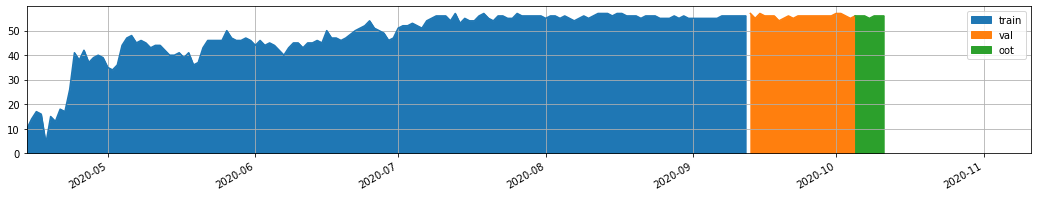

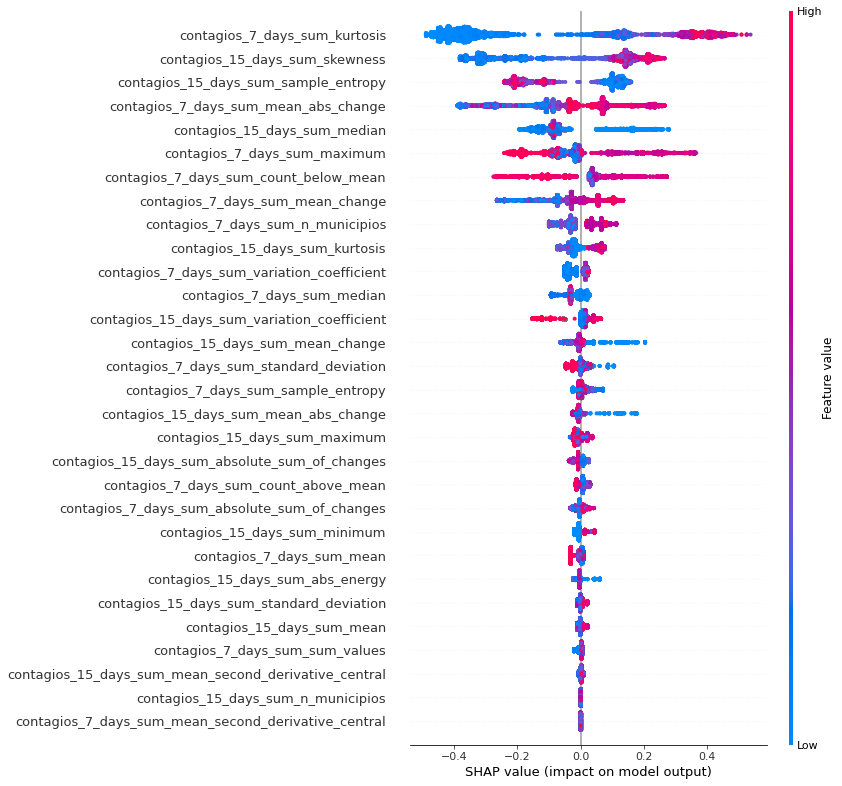

[20:33:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.990741  0.336980  0.502907   6033.0  2052.0  0.859096
1             0.270871  0.987375  0.425118   1505.0  5486.0  0.859096
avg / total   0.847015  0.466835  0.487376   7538.0  7538.0  0.859096, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.977407  0.772516  0.862966   1288.0  1018.0  0.795875
1             0.090062  0.557692  0.155080     52.0   322.0  0.795875
avg / total   0.942972  0.764179  0.835496   1340.0  1340.0  0.795875, 'oot':              precision

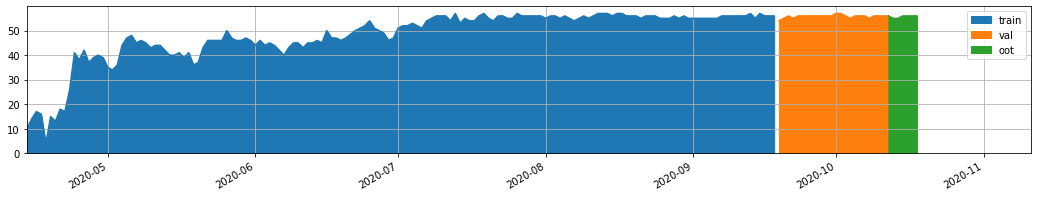

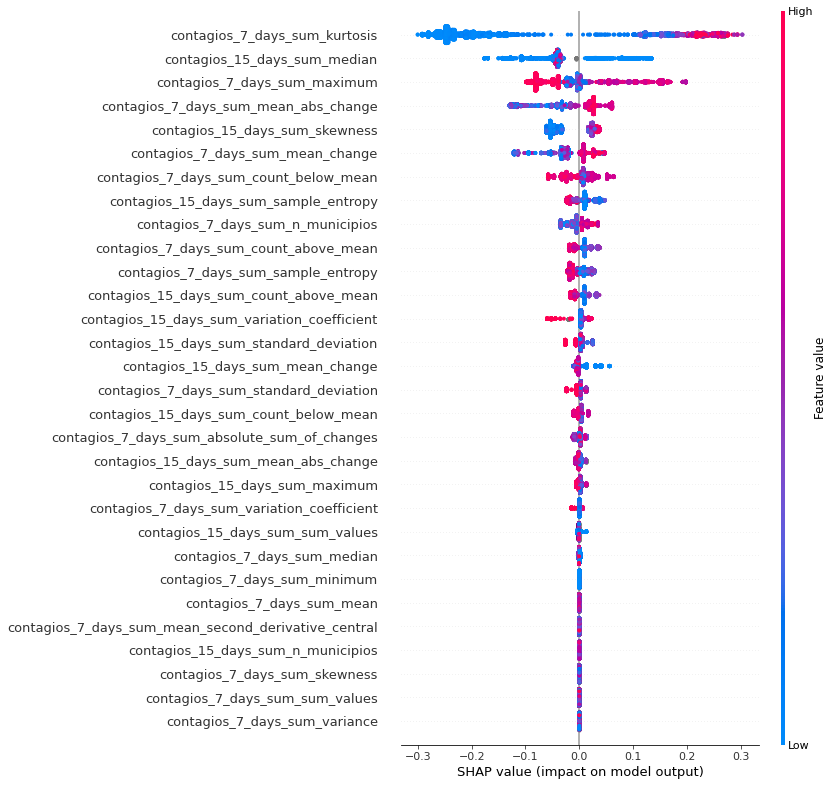

[20:33:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.998093  0.329556  0.495504   6354.0  2098.0  0.885757
1             0.261954  0.997361  0.414929   1516.0  5772.0  0.885757
avg / total   0.856291  0.458196  0.479983   7870.0  7870.0  0.885757, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.983095  0.569706  0.721374   1327.0   769.0  0.809355
1             0.092210  0.816901  0.165714     71.0   629.0  0.809355
avg / total   0.937850  0.582260  0.693154   1398.0  1398.0  0.809355, 'oot':              precision

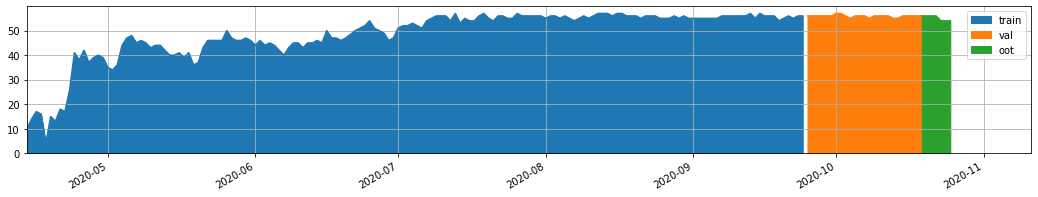

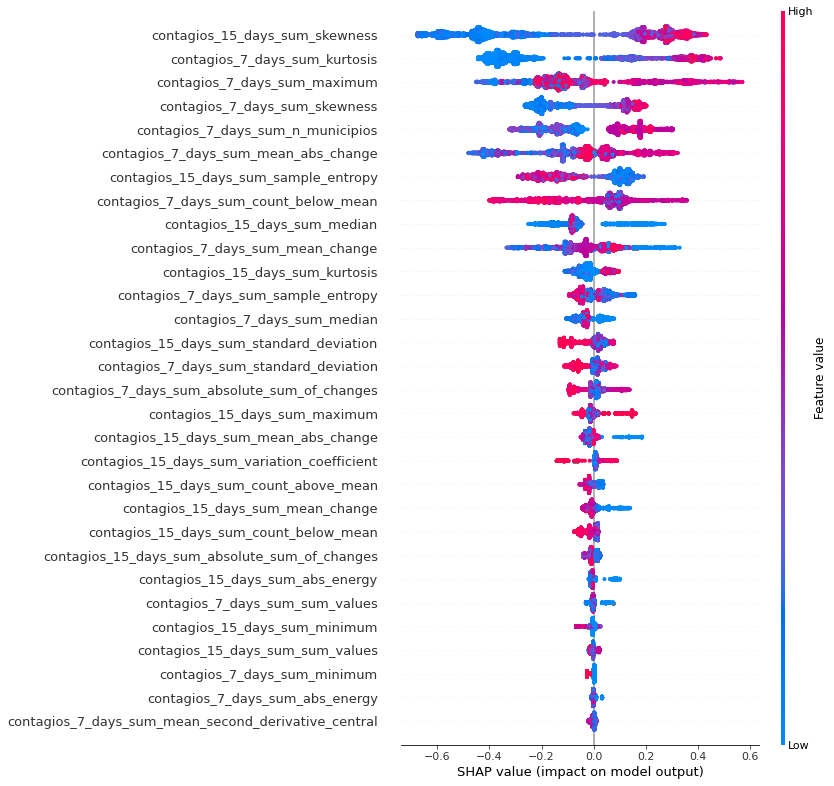

[20:33:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.997710  0.391435  0.562271   6678.0  2620.0  0.887378
1             0.272467  0.996073  0.427889   1528.0  5586.0  0.887378
avg / total   0.862666  0.504021  0.537249   8206.0  8206.0  0.887378, 'val':              precision    recall  f1-score  support    pred      AUC
0             0.975875  0.596168  0.740165   1357.0   829.0  0.76702
1             0.114701  0.780220  0.200000     91.0   619.0  0.76702
avg / total   0.921754  0.607735  0.706218   1448.0  1448.0  0.76702, 'oot':              precision    

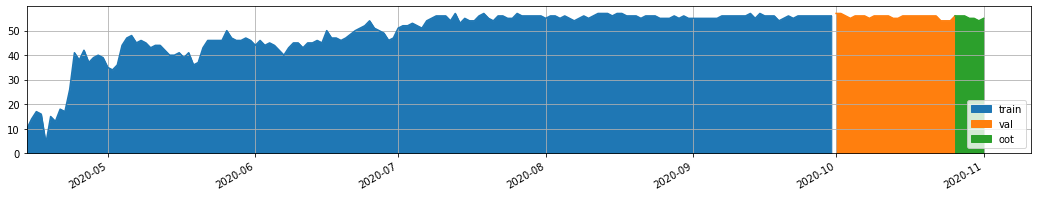

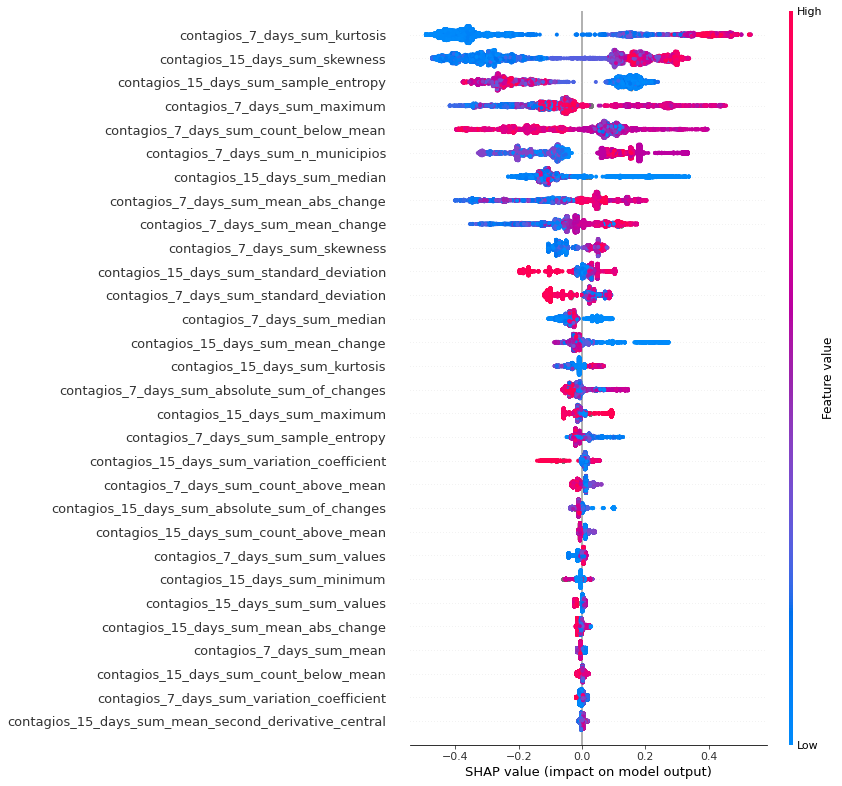

[20:33:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.993118  0.477623  0.645030   6949.0  3342.0  0.886743
1             0.294461  0.985046  0.453389   1538.0  5145.0  0.886743
avg / total   0.866508  0.569577  0.610301   8487.0  8487.0  0.886743, 'val':              precision    recall  f1-score  support    pred      AUC
0             0.949099  0.835862  0.888889   1450.0  1277.0  0.69262
1             0.134545  0.362745  0.196286    102.0   275.0  0.69262
avg / total   0.895566  0.804768  0.843370   1552.0  1552.0  0.69262, 'oot':              precision    

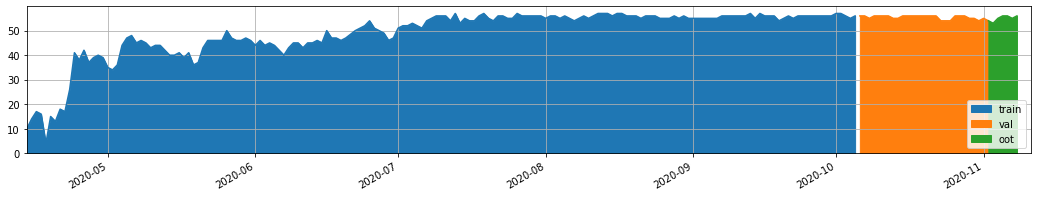

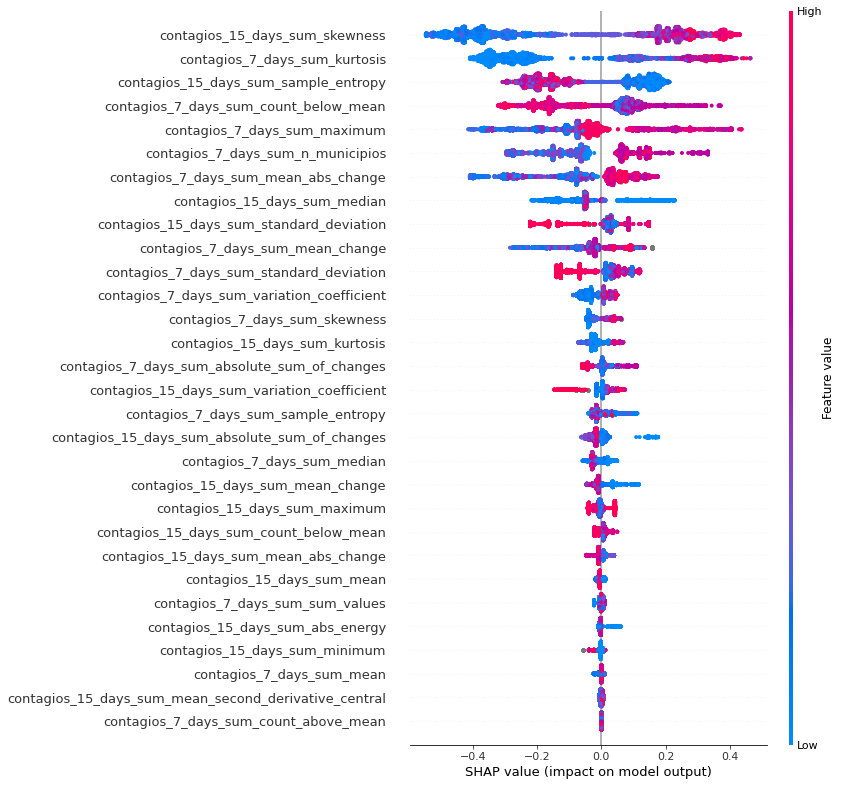

[20:33:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.993213  0.463062  0.631638   7269.0  3389.0  0.877501
1             0.281612  0.985190  0.438019   1553.0  5433.0  0.877501
avg / total   0.867945  0.554976  0.597554   8822.0  8822.0  0.877501, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.960679  0.716667  0.820924   1500.0  1119.0  0.771424
1             0.121901  0.572816  0.201022    103.0   484.0  0.771424
avg / total   0.906784  0.707424  0.781093   1603.0  1603.0  0.771424, 'oot':              precision

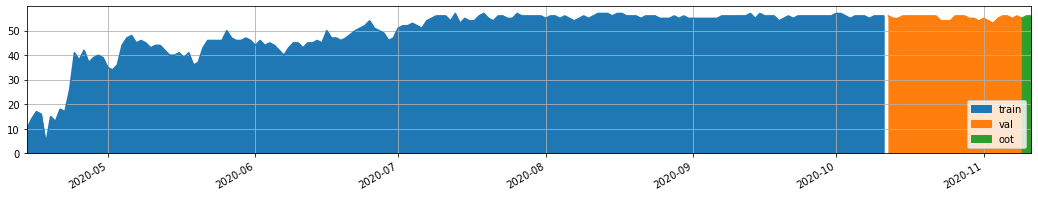

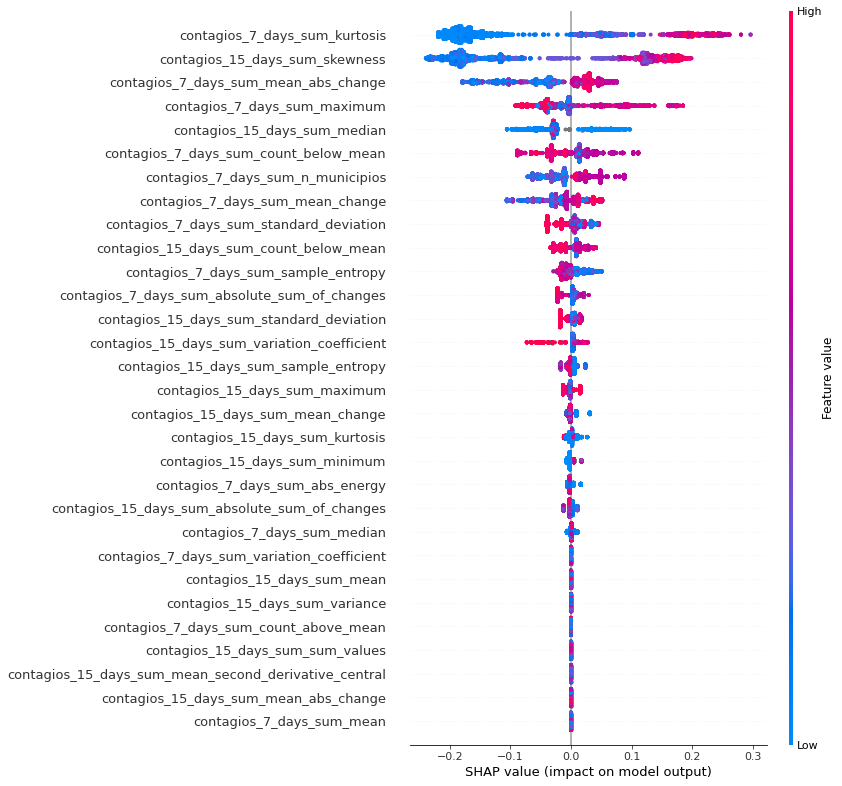

In [20]:
reports = []
for date, oot in date_data.set_index('fecha').groupby(pd.Grouper(freq='7D')):
    oot.reset_index(inplace=True)
    train = data_[data_['fecha'] <= date]

    oos_size = .15
    val_boundary = train['fecha'].quantile(1 - oos_size)

    val = train[train['fecha'] >= val_boundary]
    train = train[train['fecha'] < val_boundary]
    
    # Split data
    X_train = train.set_index(['fecha', 'nombre_hospital']).copy()
    X_train.drop(list(set(X_train.columns).intersection(forbiden)), axis=1, inplace=True)
    y_train = train.set_index(['fecha', 'nombre_hospital'])[target]

    X_val = val.set_index(['fecha', 'nombre_hospital']).copy()
    X_val.drop(list(set(X_val.columns).intersection(forbiden)), axis=1, inplace=True)
    y_val = val.set_index(['fecha', 'nombre_hospital'])[target]

    X_oot = oot.set_index(['fecha', 'nombre_hospital']).copy()
    X_oot.drop(list(set(X_oot.columns).intersection(forbiden)), axis=1, inplace=True)
    y_oot = oot.set_index(['fecha', 'nombre_hospital'])[target]
    
    plot_folds(X_train, X_val, X_oot)
    
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = xgb.XGBClassifier(
        subsample=.7,
        col_subsample=.5,
        max_depth=4,
        learning_rate=.05,
        min_child_weight=100,
        scale_pos_weight=scale_pos_weight
    )

    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=['logloss', 'auc'],
        early_stopping_rounds=10,
        verbose=False)

    y_train_score = model.predict_proba(X_train)
    y_val_score = model.predict_proba(X_val)
    y_oot_score = model.predict_proba(X_oot)

    # Evaluate
    score_th = pd.Series(y_oot_score[:, 1]).quantile(.5)
    report_train = eval_utils.classification_report(
        y_true=y_train, 
        y_score=y_train_score, 
        y_pred=(y_train_score[:, 1] > score_th).astype(int))

    report_val = eval_utils.classification_report(
        y_true=y_val, 
        y_score=y_val_score, 
        y_pred=(y_val_score[:, 1] > score_th).astype(int))

    report_oot = eval_utils.classification_report(
        y_true=y_oot, 
        y_score=y_oot_score, 
        y_pred=(y_oot_score[:, 1] > score_th).astype(int))
    
    local_reports = {
        'train': report_train,
        'val': report_val,
        'oot': report_oot,
        'date': date
    }
    
    print(local_reports)
    reports.append(local_reports)
    
#     plot_folds(X_train, X_val, X_oot)
    
    fig, ax = plt.subplots(1, 1)
    explainer = shap.TreeExplainer(model)
    
    shaps_values = pd.DataFrame(
        explainer.shap_values(X_train),
        columns=X_train.columns)

    shap.summary_plot(
        shaps_values.values, 
        X_train,
        max_display=30)

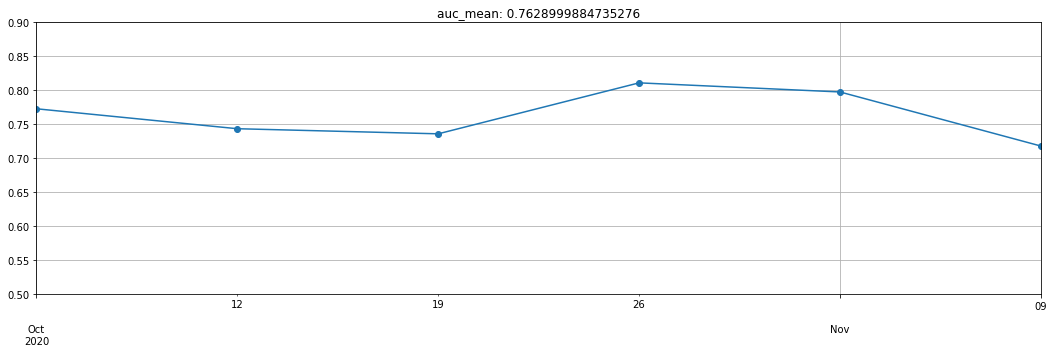

In [19]:
auc = pd.Series([r['oot']['AUC']['avg / total'] for r in reports])
auc.index = [r['date'] for r in reports]

auc_mean = auc.mean()

auc.plot(
    marker='o',
    grid=True,
    figsize=(18, 5),
    ylim=(.5, .9),
    title='auc_mean: %s' % auc_mean)